# Analysis notebook for compression algorithm benchmark

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

- The analysis can be conducted on the csv results generated by a single compiler and compilation mode.
- These should be set below using the variables `COMPILER` and `MODE` which can be set to [`clang14`, `gcc11`] and [`debug`, `release`], respectively. 
- These values will be used in the `CSV_TEMPLATE` to read the csv files. You can use other values if you have csv files with different names.
- The csv files should contain the following columns: *Filename,Size_Original,Size_Compressed,Size_Ratio,Time_Compress,Time_Decompress*



In [ ]:
COMPILER, MODE = 'clang14', 'release'
CSV_DIRECTORY = '.benchmarks/clang14/'
CSV_TEMPLATE  = '{compiler}_{mode}_{algorithm}_{level}.csv'

In [90]:
def read_csv(path):
    if os.path.exists(path):
        return pd.read_csv(path).sort_values('Size_Original', ascending=False)

lzma   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='lzma',   level=l)) for l in range(1, 10)}
lzop   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='lzop',   level=l)) for l in range(1, 10)}
gzip   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='gzip',   level=l)) for l in range(1, 10)}
bzip2  = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='bzip2',  level=l)) for l in range(1, 10)}
snappy = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='snappy', level=0)) for l in range(1, 10)}

The `get_stats` method takes a dataframe `df`, a `name`, and a value `bandwidth` in Kbps (kilobytes per second), and returns a dictionary consisting of the following keys:
- **Method:** name of the compression algorithm, string
- **Size:** total size of the uncompressed files, in KB (kilobytes)
- **Size_C:** total size of the files after compression, in KB (kilobytes)
- **Bandwidth:** bandwidth value passed as parameter, in Kbps (kilobits per second)
- **Transfer_Time:** time needed for transferring all uncompressed files (= Size / Bandwidth)
- **Transfer_Time_C:** time needed for transferring all compressed files (= Size_C / Bandwidth)
- **C_Time:** time needed for compressing all files, in seconds
- **Elapsed:** total elapsed time without compression (= Transfer_Time)
- **Elapsed_C:** total elapsed time for compressing and sending files consecutively (= C_Time + Transfer_Time_C)
- **Elapsed_S:** total elapsed time for compressing and sending files synchronously (= max{C_Time, Transfer_Time_C}) 

In [6]:
def get_stats(df, bandwidth, name=''):

    columns = ['Method', 'Size', 'Size_C', 'Bandwidth', 'Transfer_Time', 'Transfer_Time_C', 'C_Time', 'Elapsed', 'Elapsed_C', 'Elapsed_S']

    total_compression_time     = sum(df['Time_Compress'])
    total_compressed_file_size = sum(df['Size_Compressed']) / 1000  # KB
    total_original_file_size   = sum(df['Size_Original']) / 1000  # KB

    file_transfer_time_compressed = 8 * total_compressed_file_size / bandwidth 
    file_transfer_time_original   = 8 * total_original_file_size / bandwidth

    elapsed_time_stream     = max(file_transfer_time_compressed, total_compression_time)
    elapsed_time_compressed = file_transfer_time_compressed + total_compression_time
    elapsed_time_original   = file_transfer_time_original

    return {
        'Method': str(name),
        'Size': int(total_original_file_size),
        'Size_C': int(total_compressed_file_size),
        'Bandwidth': bandwidth,
        'Transfer_Time': file_transfer_time_original,
        'Transfer_Time_C': file_transfer_time_compressed,
        'C_Time': total_compression_time,
        'Elapsed': file_transfer_time_original,
        'Elapsed_C': elapsed_time_compressed,
        'Elapsed_S': elapsed_time_stream
    }

The `compare_flags` returns the stats for different `flags` of the given dataframe `df` with the given `bandwidth` size. 

In [7]:
# old name compare_elapsed

def compare_flags(df, bandwidth, name, flags=range(1, 10)):
    data = [get_stats(df[i], bandwidth, f'{name} -{i}') for i in flags]
    return pd.DataFrame.from_dict(data)

In [9]:
display(compare_flags(lzma, 6000, 'lzma'))
display(compare_flags(lzop, 6000, 'lzop'))
display(compare_flags(lzop, 6000, 'gzip'))
display(compare_flags(lzop, 6000, 'bzip2'))

,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,lzma -1,1609852,240494,6000,2146.470613,320.659685,54.732224,2146.470613,375.391910,320.659685
1,lzma -2,1609852,237739,6000,2146.470613,316.985803,66.041708,2146.470613,383.027510,316.985803
2,lzma -3,1609852,236754,6000,2146.470613,315.672736,80.534079,2146.470613,396.206815,315.672736
3,lzma -4,1609852,228478,6000,2146.470613,304.638157,216.178345,2146.470613,520.816503,304.638157
4,lzma -5,1609852,223542,6000,2146.470613,298.056265,276.139700,2146.470613,574.195965,298.056265
5,lzma -6,1609852,221987,6000,2146.470613,295.983709,325.672455,2146.470613,621.656165,325.672455
6,lzma -7,1609852,221911,6000,2146.470613,295.881459,327.730282,2146.470613,623.611741,327.730282
7,lzma -8,1609852,221896,6000,2146.470613,295.861860,336.206586,2146.470613,632.068446,336.206586
8,lzma -9,1609852,221896,6000,2146.470613,295.861860,335.899540,2146.470613,631.761400,335.899540


,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,lzop -1,1609852,509661,6000,2146.470613,679.548891,4.017227,2146.470613,683.566117,679.548891
1,lzop -2,1609852,507215,6000,2146.470613,676.286785,4.023819,2146.470613,680.310604,676.286785
2,lzop -3,1609852,507215,6000,2146.470613,676.286785,4.005106,2146.470613,680.291892,676.286785
3,lzop -4,1609852,507215,6000,2146.470613,676.286785,4.005134,2146.470613,680.291919,676.286785
4,lzop -5,1609852,507215,6000,2146.470613,676.286785,4.006125,2146.470613,680.292911,676.286785
5,lzop -6,1609852,507215,6000,2146.470613,676.286785,4.027073,2146.470613,680.313858,676.286785
6,lzop -7,1609852,396226,6000,2146.470613,528.302180,60.835625,2146.470613,589.137805,528.302180
7,lzop -8,1609852,392557,6000,2146.470613,523.410271,217.223961,2146.470613,740.634231,523.410271
8,lzop -9,1609852,392322,6000,2146.470613,523.096528,323.817158,2146.470613,846.913686,523.096528


,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,gzip -1,1609852,509661,6000,2146.470613,679.548891,4.017227,2146.470613,683.566117,679.548891
1,gzip -2,1609852,507215,6000,2146.470613,676.286785,4.023819,2146.470613,680.310604,676.286785
2,gzip -3,1609852,507215,6000,2146.470613,676.286785,4.005106,2146.470613,680.291892,676.286785
3,gzip -4,1609852,507215,6000,2146.470613,676.286785,4.005134,2146.470613,680.291919,676.286785
4,gzip -5,1609852,507215,6000,2146.470613,676.286785,4.006125,2146.470613,680.292911,676.286785
5,gzip -6,1609852,507215,6000,2146.470613,676.286785,4.027073,2146.470613,680.313858,676.286785
6,gzip -7,1609852,396226,6000,2146.470613,528.302180,60.835625,2146.470613,589.137805,528.302180
7,gzip -8,1609852,392557,6000,2146.470613,523.410271,217.223961,2146.470613,740.634231,523.410271
8,gzip -9,1609852,392322,6000,2146.470613,523.096528,323.817158,2146.470613,846.913686,523.096528


,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,bzip2 -1,1609852,509661,6000,2146.470613,679.548891,4.017227,2146.470613,683.566117,679.548891
1,bzip2 -2,1609852,507215,6000,2146.470613,676.286785,4.023819,2146.470613,680.310604,676.286785
2,bzip2 -3,1609852,507215,6000,2146.470613,676.286785,4.005106,2146.470613,680.291892,676.286785
3,bzip2 -4,1609852,507215,6000,2146.470613,676.286785,4.005134,2146.470613,680.291919,676.286785
4,bzip2 -5,1609852,507215,6000,2146.470613,676.286785,4.006125,2146.470613,680.292911,676.286785
5,bzip2 -6,1609852,507215,6000,2146.470613,676.286785,4.027073,2146.470613,680.313858,676.286785
6,bzip2 -7,1609852,396226,6000,2146.470613,528.302180,60.835625,2146.470613,589.137805,528.302180
7,bzip2 -8,1609852,392557,6000,2146.470613,523.410271,217.223961,2146.470613,740.634231,523.410271
8,bzip2 -9,1609852,392322,6000,2146.470613,523.096528,323.817158,2146.470613,846.913686,523.096528


The `compare_best` method takes a `bandwidth` value and returns the best performing stats (which uses the flag yielding the minimal value for `Elapsed_S` column) for the hardcoded algorithms. Change according to your needs. If `highlight` option is true, it returns a styled dataframe which highlights the best row.

In [56]:
def compare_best(bandwidth, column='Elapsed_S', highlight=False):

    lzma_elap = compare_flags(lzma, bandwidth, 'lzma')
    lzma_best = lzma_elap.iloc[[lzma_elap[column].idxmin()], :]

    lzop_elap = compare_flags(lzop, bandwidth, 'lzop')
    lzop_best = lzop_elap.iloc[[lzop_elap[column].idxmin()], :]

    gzip_elap = compare_flags(gzip, bandwidth, 'gzip')
    gzip_best = gzip_elap.iloc[[gzip_elap[column].idxmin()], :]

    bzip2_elap = compare_flags(bzip2, bandwidth, 'bzip2')
    bzip2_best = bzip2_elap.iloc[[bzip2_elap[column].idxmin()], :]

    snappy_elap = compare_flags(snappy, bandwidth, 'snappy')
    snappy_best = snappy_elap.iloc[[snappy_elap[column].idxmin()], :]

    df = pd.concat([lzma_best, lzop_best, gzip_best, bzip2_best, snappy_best]).reset_index()

    if highlight:
        best = df[column].min()

        def highlight(row):
            if row[column] == best:
                return ['background-color: blue'] * (len(lzma_elap.columns) + 1)
            else:
                return ['background-color: default'] * (len(lzma_elap.columns) + 1)
    
        return df.style.apply(highlight, axis=1)
    
    return df

In [60]:
display(compare_best(6000, highlight=True))
display(compare_best(226000, highlight=True))
display(compare_best(250000, highlight=True))
display(compare_best(300000, highlight=True))
display(compare_best(1000000, highlight=True))
display(compare_best(10000000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,4,lzma -5,1609852,223542,6000,2146.470613,298.056265,276.139700,2146.470613,574.195965,298.056265
1,8,lzop -9,1609852,392322,6000,2146.470613,523.096528,323.817158,2146.470613,846.913686,523.096528
2,8,gzip -9,1609852,329878,6000,2146.470613,439.837773,218.674965,2146.470613,658.512739,439.837773
3,2,bzip2 -3,1609852,329131,6000,2146.470613,438.841685,114.907379,2146.470613,553.749065,438.841685
4,0,snappy -1,1609852,538805,6000,2146.470613,718.407288,27.275026,2146.470613,745.682314,718.407288


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,226000,56.985945,8.513089,54.732224,56.985945,63.245313,54.732224
1,1,lzop -2,1609852,507215,226000,56.985945,17.954516,4.023819,56.985945,21.978335,17.954516
2,0,gzip -1,1609852,375603,226000,56.985945,13.295704,17.990366,56.985945,31.286069,17.990366
3,1,bzip2 -2,1609852,329628,226000,56.985945,11.668251,113.953713,56.985945,125.621963,113.953713
4,0,snappy -1,1609852,538805,226000,56.985945,19.072760,27.275026,56.985945,46.347786,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,250000,51.515295,7.695832,54.732224,51.515295,62.428057,54.732224
1,1,lzop -2,1609852,507215,250000,51.515295,16.230883,4.023819,51.515295,20.254701,16.230883
2,0,gzip -1,1609852,375603,250000,51.515295,12.019316,17.990366,51.515295,30.009682,17.990366
3,1,bzip2 -2,1609852,329628,250000,51.515295,10.548099,113.953713,51.515295,124.501811,113.953713
4,0,snappy -1,1609852,538805,250000,51.515295,17.241775,27.275026,51.515295,44.516801,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,300000,42.929412,6.413194,54.732224,42.929412,61.145418,54.732224
1,1,lzop -2,1609852,507215,300000,42.929412,13.525736,4.023819,42.929412,17.549554,13.525736
2,0,gzip -1,1609852,375603,300000,42.929412,10.016097,17.990366,42.929412,28.006463,17.990366
3,1,bzip2 -2,1609852,329628,300000,42.929412,8.790082,113.953713,42.929412,122.743795,113.953713
4,0,snappy -1,1609852,538805,300000,42.929412,14.368146,27.275026,42.929412,41.643172,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,1000000,12.878824,1.923958,54.732224,12.878824,56.656182,54.732224
1,1,lzop -2,1609852,507215,1000000,12.878824,4.057721,4.023819,12.878824,8.081539,4.057721
2,0,gzip -1,1609852,375603,1000000,12.878824,3.004829,17.990366,12.878824,20.995195,17.990366
3,1,bzip2 -2,1609852,329628,1000000,12.878824,2.637025,113.953713,12.878824,116.590737,113.953713
4,0,snappy -1,1609852,538805,1000000,12.878824,4.310444,27.275026,12.878824,31.585470,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,10000000,1.287882,0.192396,54.732224,1.287882,54.924620,54.732224
1,2,lzop -3,1609852,507215,10000000,1.287882,0.405772,4.005106,1.287882,4.410878,4.005106
2,0,gzip -1,1609852,375603,10000000,1.287882,0.300483,17.990366,1.287882,18.290849,17.990366
3,1,bzip2 -2,1609852,329628,10000000,1.287882,0.263702,113.953713,1.287882,114.217415,113.953713
4,0,snappy -1,1609852,538805,10000000,1.287882,0.431044,27.275026,1.287882,27.706071,27.275026


In [52]:
display(compare_best(6000, highlight=True))
display(compare_best(226000, highlight=True))
display(compare_best(250000, highlight=True))
display(compare_best(300000, highlight=True))
display(compare_best(1000000, highlight=True))
display(compare_best(10000000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,4,lzma -5,1609852,223542,6000,2146.470613,298.056265,276.139700,2146.470613,574.195965,298.056265
1,8,lzop -9,1609852,392322,6000,2146.470613,523.096528,323.817158,2146.470613,846.913686,523.096528
2,8,gzip -9,1609852,329878,6000,2146.470613,439.837773,218.674965,2146.470613,658.512739,439.837773
3,2,bzip2 -3,1609852,329131,6000,2146.470613,438.841685,114.907379,2146.470613,553.749065,438.841685
4,0,snappy -1,1609852,538805,6000,2146.470613,718.407288,27.275026,2146.470613,745.682314,718.407288


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,226000,56.985945,8.513089,54.732224,56.985945,63.245313,54.732224
1,1,lzop -2,1609852,507215,226000,56.985945,17.954516,4.023819,56.985945,21.978335,17.954516
2,0,gzip -1,1609852,375603,226000,56.985945,13.295704,17.990366,56.985945,31.286069,17.990366
3,1,bzip2 -2,1609852,329628,226000,56.985945,11.668251,113.953713,56.985945,125.621963,113.953713
4,0,snappy -1,1609852,538805,226000,56.985945,19.072760,27.275026,56.985945,46.347786,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,250000,51.515295,7.695832,54.732224,51.515295,62.428057,54.732224
1,1,lzop -2,1609852,507215,250000,51.515295,16.230883,4.023819,51.515295,20.254701,16.230883
2,0,gzip -1,1609852,375603,250000,51.515295,12.019316,17.990366,51.515295,30.009682,17.990366
3,1,bzip2 -2,1609852,329628,250000,51.515295,10.548099,113.953713,51.515295,124.501811,113.953713
4,0,snappy -1,1609852,538805,250000,51.515295,17.241775,27.275026,51.515295,44.516801,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,300000,42.929412,6.413194,54.732224,42.929412,61.145418,54.732224
1,1,lzop -2,1609852,507215,300000,42.929412,13.525736,4.023819,42.929412,17.549554,13.525736
2,0,gzip -1,1609852,375603,300000,42.929412,10.016097,17.990366,42.929412,28.006463,17.990366
3,1,bzip2 -2,1609852,329628,300000,42.929412,8.790082,113.953713,42.929412,122.743795,113.953713
4,0,snappy -1,1609852,538805,300000,42.929412,14.368146,27.275026,42.929412,41.643172,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,1000000,12.878824,1.923958,54.732224,12.878824,56.656182,54.732224
1,1,lzop -2,1609852,507215,1000000,12.878824,4.057721,4.023819,12.878824,8.081539,4.057721
2,0,gzip -1,1609852,375603,1000000,12.878824,3.004829,17.990366,12.878824,20.995195,17.990366
3,1,bzip2 -2,1609852,329628,1000000,12.878824,2.637025,113.953713,12.878824,116.590737,113.953713
4,0,snappy -1,1609852,538805,1000000,12.878824,4.310444,27.275026,12.878824,31.585470,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,10000000,1.287882,0.192396,54.732224,1.287882,54.924620,54.732224
1,2,lzop -3,1609852,507215,10000000,1.287882,0.405772,4.005106,1.287882,4.410878,4.005106
2,0,gzip -1,1609852,375603,10000000,1.287882,0.300483,17.990366,1.287882,18.290849,17.990366
3,1,bzip2 -2,1609852,329628,10000000,1.287882,0.263702,113.953713,1.287882,114.217415,113.953713
4,0,snappy -1,1609852,538805,10000000,1.287882,0.431044,27.275026,1.287882,27.706071,27.275026


In [53]:
display(compare_best(50000, highlight=True))
display(compare_best(100000, highlight=True))
display(compare_best(200000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,50000,257.576474,38.479162,54.732224,257.576474,93.211387,54.732224
1,6,lzop -7,1609852,396226,50000,257.576474,63.396262,60.835625,257.576474,124.231887,63.396262
2,6,gzip -7,1609852,331221,50000,257.576474,52.995452,49.342966,257.576474,102.338419,52.995452
3,1,bzip2 -2,1609852,329628,50000,257.576474,52.740494,113.953713,257.576474,166.694206,113.953713
4,0,snappy -1,1609852,538805,50000,257.576474,86.208875,27.275026,257.576474,113.483901,86.208875


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,100000,128.788237,19.239581,54.732224,128.788237,73.971805,54.732224
1,1,lzop -2,1609852,507215,100000,128.788237,40.577207,4.023819,128.788237,44.601026,40.577207
2,3,gzip -4,1609852,345220,100000,128.788237,27.617607,23.822818,128.788237,51.440425,27.617607
3,1,bzip2 -2,1609852,329628,100000,128.788237,26.370247,113.953713,128.788237,140.323959,113.953713
4,0,snappy -1,1609852,538805,100000,128.788237,43.104437,27.275026,128.788237,70.379464,43.104437


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,200000,64.394118,9.619791,54.732224,64.394118,64.352015,54.732224
1,1,lzop -2,1609852,507215,200000,64.394118,20.288604,4.023819,64.394118,24.312422,20.288604
2,0,gzip -1,1609852,375603,200000,64.394118,15.024145,17.990366,64.394118,33.014511,17.990366
3,1,bzip2 -2,1609852,329628,200000,64.394118,13.185123,113.953713,64.394118,127.138836,113.953713
4,0,snappy -1,1609852,538805,200000,64.394118,21.552219,27.275026,64.394118,48.827245,27.275026


In [61]:
display(compare_best(500, highlight=True))
display(compare_best(1000, highlight=True))
display(compare_best(10000, highlight=True))
display(compare_best(20000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,7,lzma -8,1609852,221896,500,25757.647360,3550.342320,336.206586,25757.647360,3886.548906,3550.342320
1,8,lzop -9,1609852,392322,500,25757.647360,6277.158336,323.817158,25757.647360,6600.975494,6277.158336
2,8,gzip -9,1609852,329878,500,25757.647360,5278.053280,218.674965,25757.647360,5496.728245,5278.053280
3,2,bzip2 -3,1609852,329131,500,25757.647360,5266.100224,114.907379,25757.647360,5381.007603,5266.100224
4,0,snappy -1,1609852,538805,500,25757.647360,8620.887456,27.275026,25757.647360,8648.162482,8620.887456


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,7,lzma -8,1609852,221896,1000,12878.823680,1775.171160,336.206586,12878.823680,2111.377746,1775.171160
1,8,lzop -9,1609852,392322,1000,12878.823680,3138.579168,323.817158,12878.823680,3462.396326,3138.579168
2,8,gzip -9,1609852,329878,1000,12878.823680,2639.026640,218.674965,12878.823680,2857.701605,2639.026640
3,2,bzip2 -3,1609852,329131,1000,12878.823680,2633.050112,114.907379,12878.823680,2747.957491,2633.050112
4,0,snappy -1,1609852,538805,1000,12878.823680,4310.443728,27.275026,12878.823680,4337.718754,4310.443728


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,2,lzma -3,1609852,236754,10000,1287.882368,189.403642,80.534079,1287.882368,269.937721,189.403642
1,7,lzop -8,1609852,392557,10000,1287.882368,314.046162,217.223961,1287.882368,531.270123,314.046162
2,8,gzip -9,1609852,329878,10000,1287.882368,263.902664,218.674965,1287.882368,482.577629,263.902664
3,2,bzip2 -3,1609852,329131,10000,1287.882368,263.305011,114.907379,1287.882368,378.212391,263.305011
4,0,snappy -1,1609852,538805,10000,1287.882368,431.044373,27.275026,1287.882368,458.319399,431.044373


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,2,lzma -3,1609852,236754,20000,643.941184,94.701821,80.534079,643.941184,175.235900,94.701821
1,6,lzop -7,1609852,396226,20000,643.941184,158.490654,60.835625,643.941184,219.326279,158.490654
2,7,gzip -8,1609852,329999,20000,643.941184,131.999753,106.433541,643.941184,238.433294,131.999753
3,2,bzip2 -3,1609852,329131,20000,643.941184,131.652506,114.907379,643.941184,246.559885,131.652506
4,0,snappy -1,1609852,538805,20000,643.941184,215.522186,27.275026,643.941184,242.797213,215.522186


In [67]:
def get_best_flag_value(df, column='Elapsed_S'):
    return df[column].idxmin() + 1

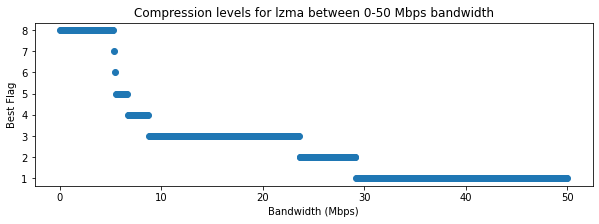

In [75]:
xs = np.linspace(1, 50000, 600)
ys = [get_best_flag_value(compare_flags(lzma, bandwidth, 'lzma')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzma between 0-50 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)


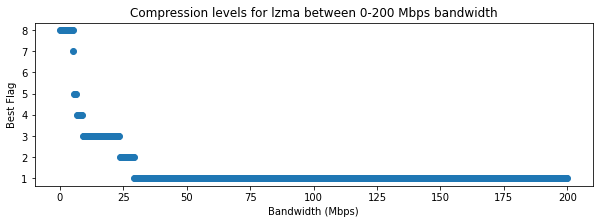

In [73]:
xs = np.linspace(1, 200000, 600)
ys = [get_best_flag_value(compare_flags(lzma, bandwidth, 'lzma')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzma between 0-200 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)


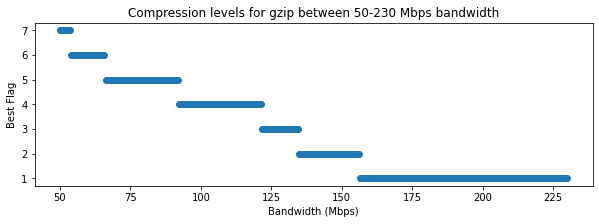

In [77]:
xs = np.linspace(50000, 230000, 400)
ys = [get_best_flag_value(compare_flags(gzip, bandwidth, 'gzip')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for gzip between 50-230 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,400000,32.197059,4.809895,54.732224,32.197059,59.542120,54.732224
1,1,lzop -2,1609852,507215,400000,32.197059,10.144302,4.023819,32.197059,14.168120,10.144302
2,0,gzip -1,1609852,375603,400000,32.197059,7.512073,17.990366,32.197059,25.502438,17.990366
3,1,bzip2 -2,1609852,329628,400000,32.197059,6.592562,113.953713,32.197059,120.546274,113.953713
4,0,snappy -1,1609852,538805,400000,32.197059,10.776109,27.275026,32.197059,38.051136,27.275026


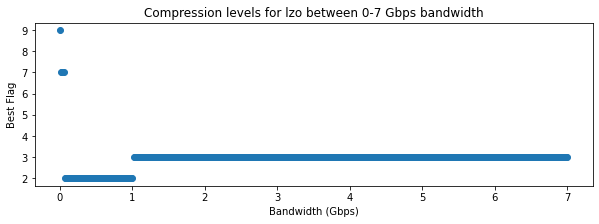

In [81]:
xs = np.linspace(1, 7000000, 400)
ys = [get_best_flag_value(compare_flags(lzop, bandwidth, 'lzop')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Gbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzo between 0-7 Gbps bandwidth')
_ = plt.scatter(xs / 1e6, ys)

compare_best(400000, highlight=True)

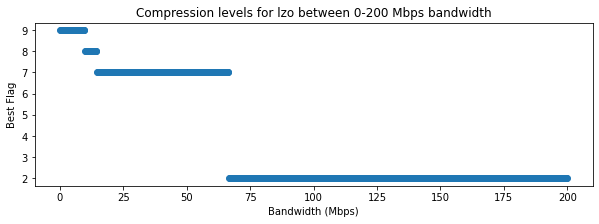

In [82]:
xs = np.linspace(1, 200000, 600)
ys = [get_best_flag_value(compare_flags(lzop, bandwidth, 'lzop')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzo between 0-200 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,40000,321.970592,48.098953,54.732224,321.970592,102.831177,54.732224
1,6,lzop -7,1609852,396226,40000,321.970592,79.245327,60.835625,321.970592,140.080952,79.245327
2,6,gzip -7,1609852,331221,40000,321.970592,66.244315,49.342966,321.970592,115.587282,66.244315
3,1,bzip2 -2,1609852,329628,40000,321.970592,65.925617,113.953713,321.970592,179.879330,113.953713
4,0,snappy -1,1609852,538805,40000,321.970592,107.761093,27.275026,321.970592,135.036120,107.761093


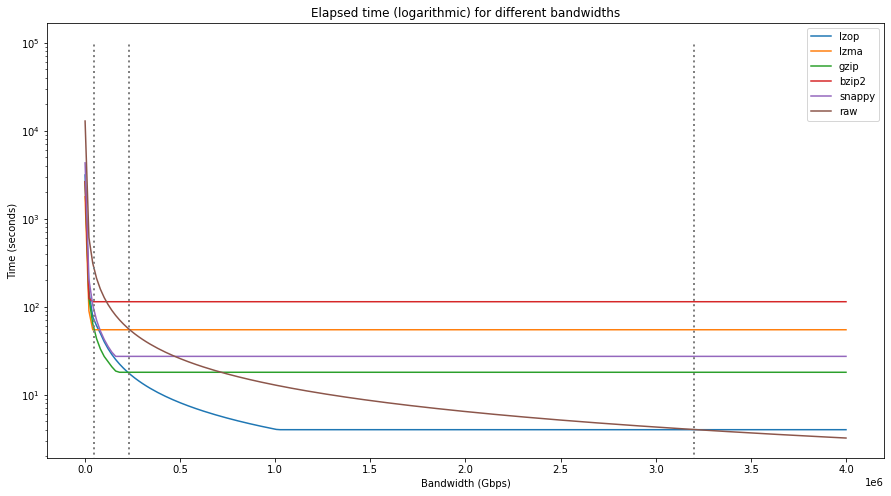

In [83]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 4000000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]


#xs /= 1e6
plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Gbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs, y1, label='lzop')
plt.plot(xs, y2, label='lzma')
plt.plot(xs, y3, label='gzip')
plt.plot(xs, y4, label='bzip2')
plt.plot(xs, y5, label='snappy')
plt.plot(xs, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
plt.vlines(x=47000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=230000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=3200000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.legend()

display(compare_best(40000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,1,lzma -2,1609852,237739,25000,515.152947,76.076593,66.041708,515.152947,142.118300,76.076593
1,6,lzop -7,1609852,396226,25000,515.152947,126.792523,60.835625,515.152947,187.628148,126.792523
2,6,gzip -7,1609852,331221,25000,515.152947,105.990905,49.342966,515.152947,155.333871,105.990905
3,1,bzip2 -2,1609852,329628,25000,515.152947,105.480987,113.953713,515.152947,219.434700,113.953713
4,0,snappy -1,1609852,538805,25000,515.152947,172.417749,27.275026,515.152947,199.692775,172.417749


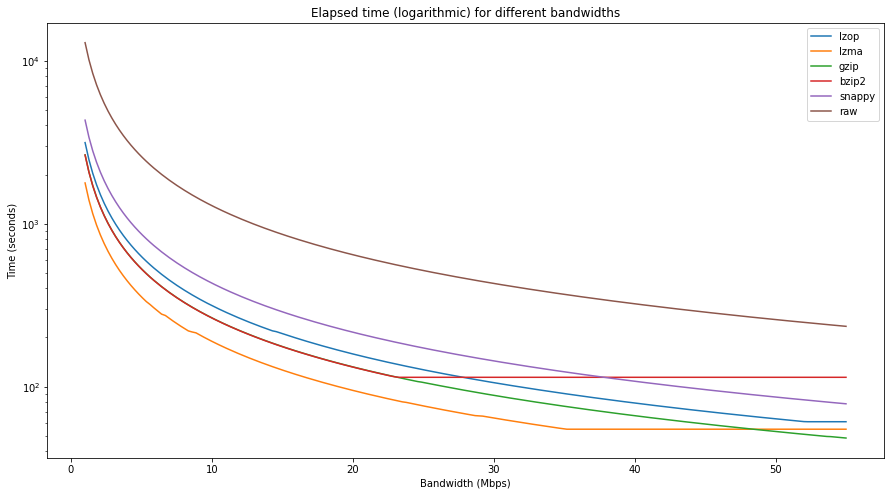

In [84]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 55000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')

plt.legend()

display(compare_best(25000, highlight=True))



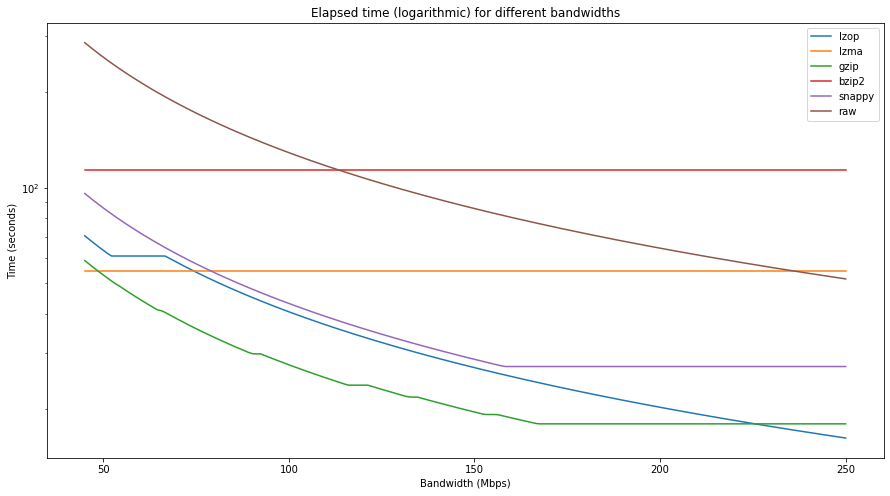

In [85]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(45000, 250000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')

_ = plt.legend()

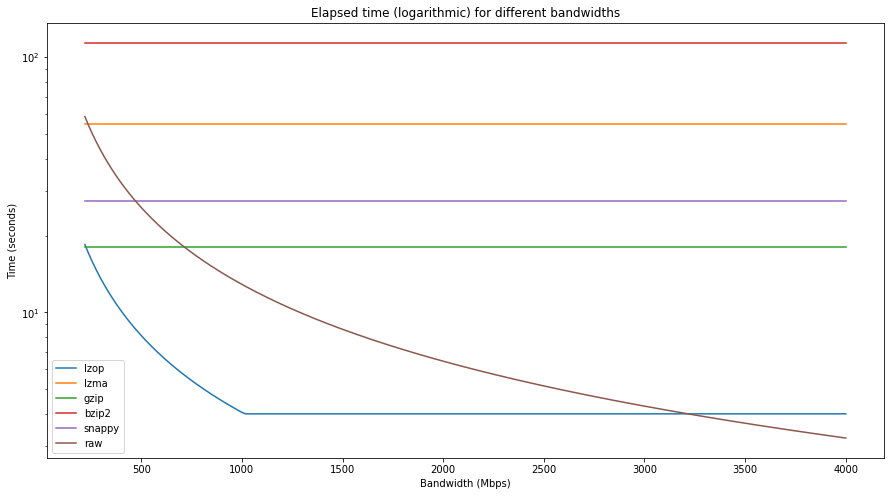

In [86]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(220000, 4000000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')

_ = plt.legend()

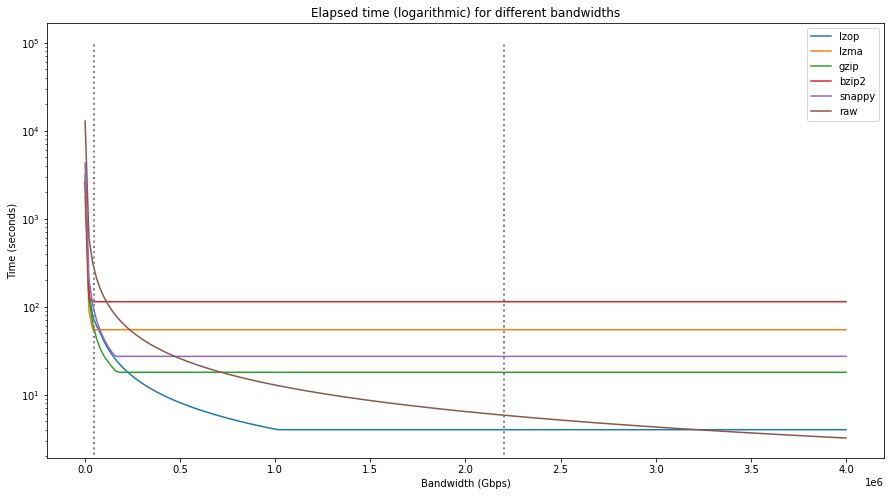

In [87]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 4000000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Gbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs, y1, label='lzop')
plt.plot(xs, y2, label='lzma')
plt.plot(xs, y3, label='gzip')
plt.plot(xs, y4, label='bzip2')
plt.plot(xs, y5, label='snappy')
plt.plot(xs, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
plt.vlines(x=47000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=2200000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
_ = plt.legend()


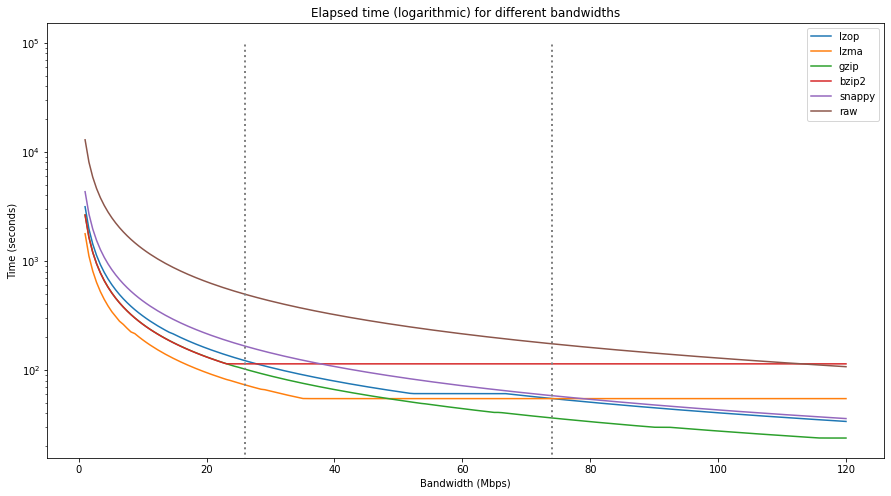

In [88]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 120000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(15, 8))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
plt.vlines(x=26, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=74, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)

_ = plt.legend()


In [89]:
display(compare_best(4000000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,4000000,3.219706,0.480990,54.732224,3.219706,55.213214,54.732224
1,2,lzop -3,1609852,507215,4000000,3.219706,1.014430,4.005106,3.219706,5.019536,4.005106
2,0,gzip -1,1609852,375603,4000000,3.219706,0.751207,17.990366,3.219706,18.741573,17.990366
3,1,bzip2 -2,1609852,329628,4000000,3.219706,0.659256,113.953713,3.219706,114.612969,113.953713
4,0,snappy -1,1609852,538805,4000000,3.219706,1.077611,27.275026,3.219706,28.352637,27.275026
